In [35]:
import numpy as np
import pandas as pd
import os
import scipy
import scipy.signal
import sys

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

sys.path.append('../quest_gnc/build36/')
from quest_gncpy import *

In [36]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)

def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)

In [37]:
imu_file=os.path.expanduser('~/Documents/log/2019-04-05T16-31-07/logstream_ImuNoCov.bin')
odom_file=os.path.expanduser('~/Documents/log/2019-04-05T16-31-07/logstream_OdomNoCov.bin')

In [38]:
imu = np.dtype([('recvSec', '>u4'), ('recvUsec', '>u4'),
               
                ('seq', '>u4'),
                ('timeBase', '>u2'), ('timeContext', '>u1'), ('timeSec', '>u4'), ('timeUsec', '>u4'),
                ('frame_id', '>u4'),
               
                ('qx', '>f8'), ('qy', '>f8'), ('qz', '>f8'), ('qw', '>f8'),

                ('wx', '>f8'), ('wy', '>f8'), ('wz', '>f8'),

                ('ax', '>f8'), ('ay', '>f8'), ('az', '>f8')])

odom = np.dtype([('recvSec', '>u4'), ('recvUsec', '>u4'),
               
                 ('seq', '>u4'),
                 ('timeBase', '>u2'), ('timeContext', '>u1'), ('timeSec', '>u4'), ('timeUsec', '>u4'),
                 ('frame_id', '>u4'),
                 
                 ('child_frame_id', '>u4'),

                 ('x', '>f8'), ('y', '>f8'), ('z', '>f8'),
               
                 ('qx', '>f8'), ('qy', '>f8'), ('qz', '>f8'), ('qw', '>f8'),

                 ('vx', '>f8'), ('vy', '>f8'), ('vz', '>f8'),

                 ('wx', '>f8'), ('wy', '>f8'), ('wz', '>f8')])

In [39]:
imu_dat = np.fromfile(imu_file, dtype=imu)
imu_df = pd.DataFrame(imu_dat.byteswap().newbyteorder())

In [40]:
odom_dat = np.fromfile(odom_file, dtype=odom)
odom_df = pd.DataFrame(odom_dat.byteswap().newbyteorder())

In [41]:
imu_time = imu_df.timeSec + imu_df.timeUsec / (1000.0 * 1000.0)
odom_time = odom_df.timeSec + odom_df.timeUsec / (1000.0 * 1000.0)

In [42]:
a = AttFilter()
a.SetTimeStep(0.0009765625)
a.SetAccelGain(0.01)
a.SetBiasAlpha(0.01)
a.SetSteadyStateThresh(0.5, 0.01, 0.2)

x_w = np.ndarray(shape=(3,imu_time.size), dtype=float)
w_euler_b = np.ndarray(shape=(3,imu_time.size), dtype=float)
w_q_b = np.ndarray(shape=(4,imu_time.size), dtype=float)
v_b = np.ndarray(shape=(3,imu_time.size), dtype=float)
omega_b = np.ndarray(shape=(3,imu_time.size), dtype=float)

In [43]:
for index, row in imu_df.iterrows():
    i = ImuSample()
    i.t = imu_time[index]
    i.omega_b = [row.wx, row.wy, row.wz]
    i.a_b = [row.ax, row.ay, row.az]
    a.AddImu(i)
    a.PropagateState()
    x_w[:, index], w_euler_b[:, index], w_q_b[:, index], v_b[:, index], omega_b[:, index], _ = a.GetState()

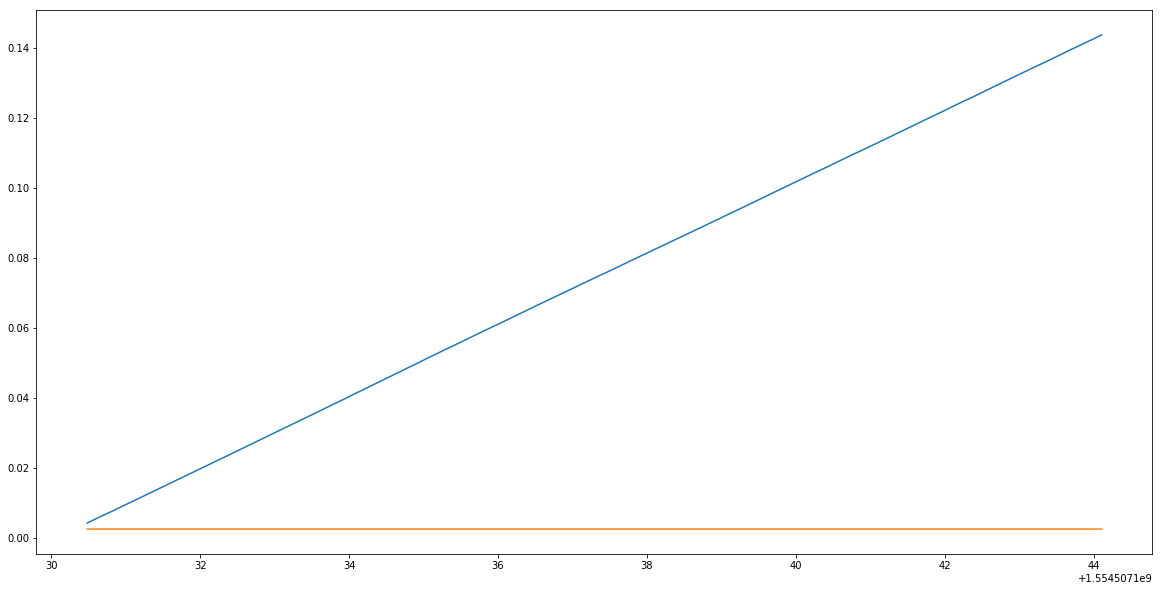

In [44]:
plt.plot(imu_time, w_q_b[0, :], '')
plt.plot(odom_time, odom_df.qx, '')

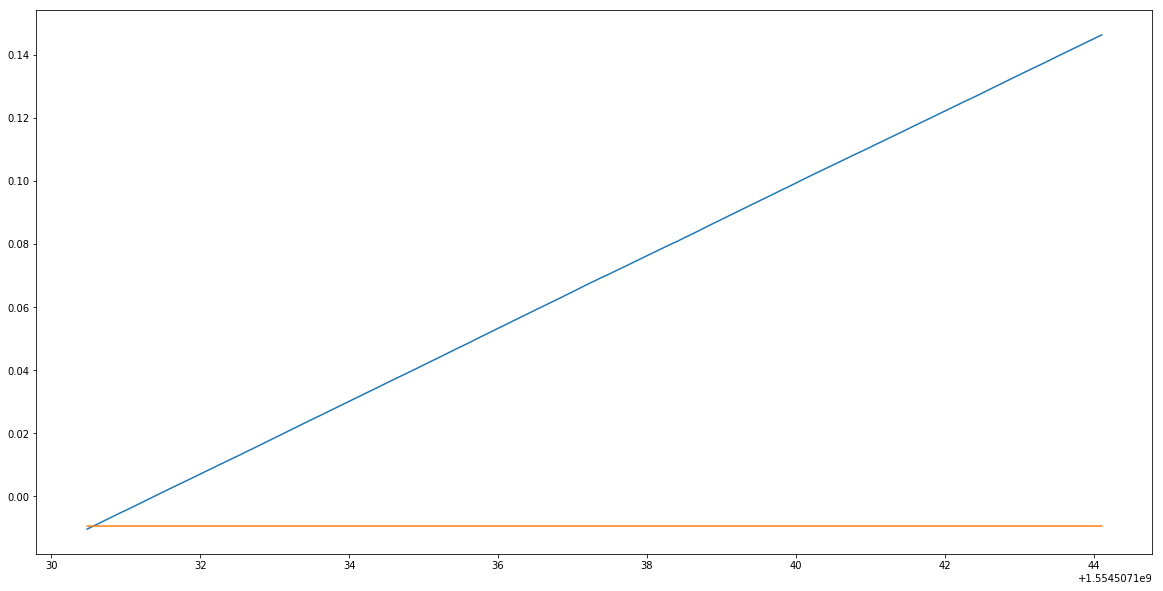

In [45]:
plt.plot(imu_time, w_q_b[1, :], '')
plt.plot(odom_time, odom_df.qy, '')

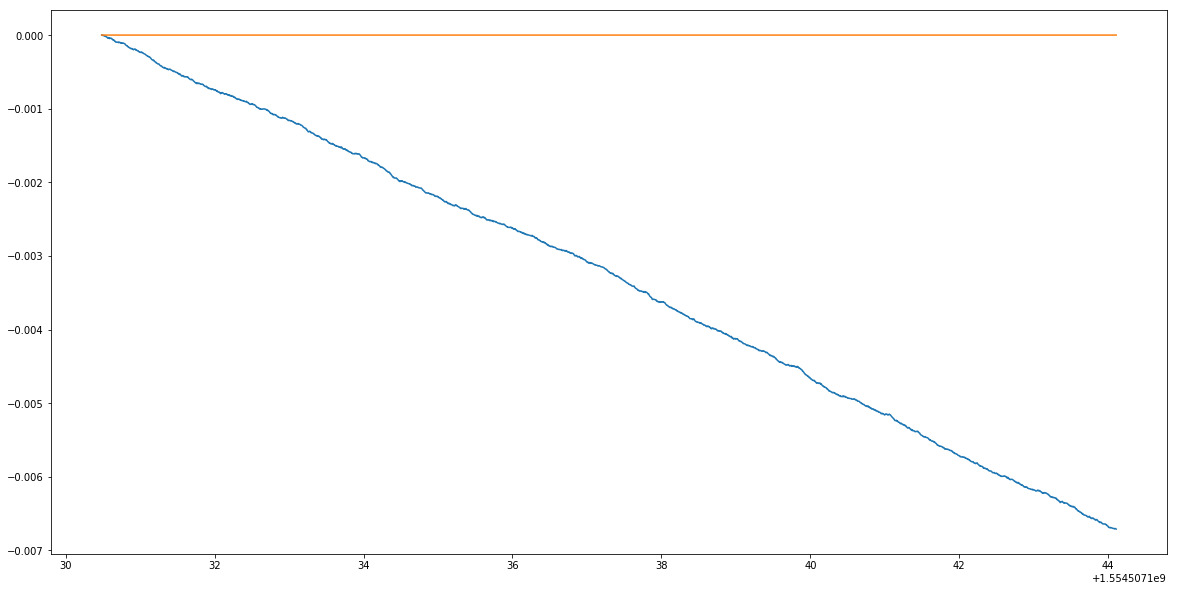

In [46]:
plt.plot(imu_time, w_q_b[2, :], '')
plt.plot(odom_time, odom_df.qz, '')

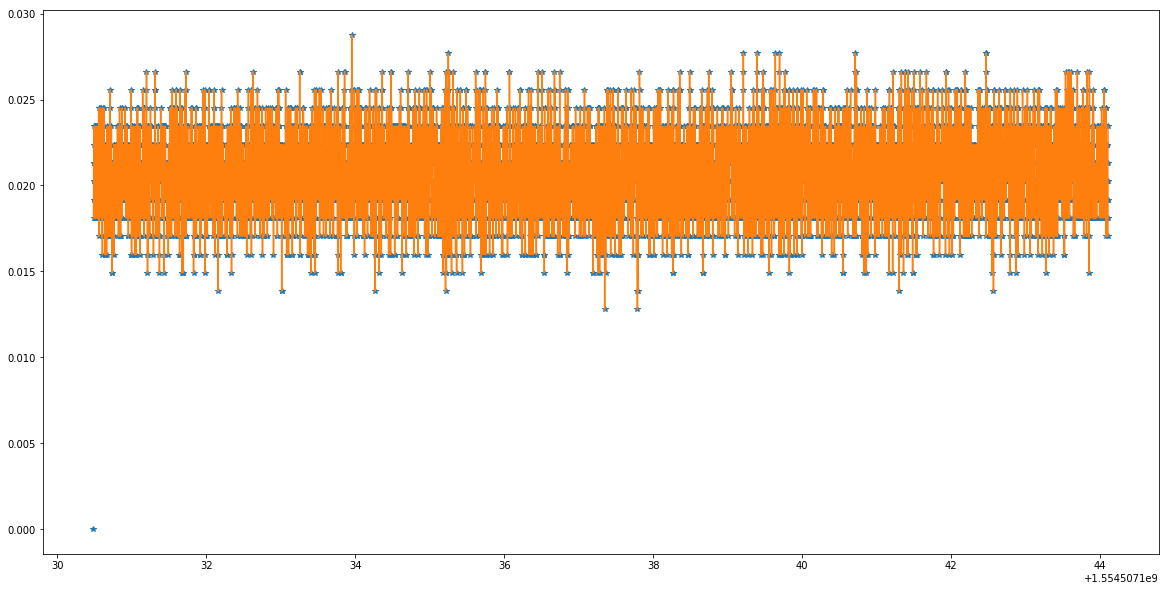

In [47]:
plt.plot(imu_time, omega_b[0, :], '*')
plt.plot(odom_time, odom_df.wx, '')

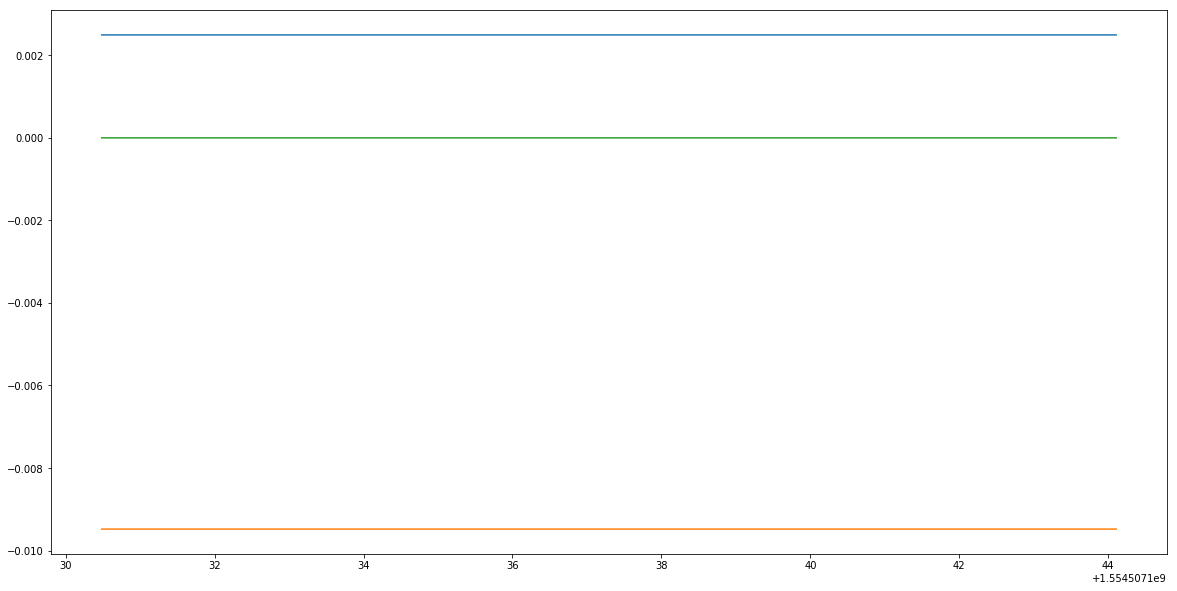

In [48]:
plt.plot(odom_time, odom_df.qx, '')
plt.plot(odom_time, odom_df.qy, '')
plt.plot(odom_time, odom_df.qz, '')